# Evaluation

In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from utils import eda_utils, evaluation_utils
import numpy as np

d:\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ml_eval_df = pd.DataFrame(columns=['method', 'mae', 'mse', 'rmse', 'r2', 'adjusted_r2'])
si_eval_df = pd.DataFrame(columns=['method', 'mae', 'mse', 'rmse', 'r2', 'adjusted_r2'])

ml_error_df = pd.DataFrame(columns=['bin', 'method', 'y_true', 'y_pred', 'error'])
si_error_df = pd.DataFrame(columns=['bin', 'method', 'y_true', 'y_pred', 'error'])

## Autogluon top 5 model Evaluation

- boxplot: dis_bin-wise distribution, error distribution
- barplot: dis_bin-wise rmse, adjusted_r2
- output: csv

In [3]:
test_df = pd.read_csv('data/241026_Rockhead_Seoul_test(before_aumentation).csv')

In [4]:
test = TabularDataset(test_df.drop(['dis_bin'], axis=1))

In [5]:
predictor = TabularPredictor.load('AutogluonModels\\ag-20241026_112102')
ld_board = predictor.leaderboard(test, silent=True)

In [6]:
for i in range(5):
    
    error_df = pd.DataFrame(columns=['bin', 'method', 'y_true', 'y_pred', 'error'])

    for bin in test_df['dis_bin'].unique():

        bin_df = test_df[test_df['dis_bin'] == bin]
                                
        X_test_bin = TabularDataset(bin_df.drop(['depth_start', 'dis_bin'], axis=1))
        y_test_bin = bin_df['depth_start'].array

        pred_y = predictor.predict(X_test_bin, ld_board.model[i])

        error = {'bin':np.full(y_test_bin.shape, bin), 'method':np.full(y_test_bin.shape, ld_board.model[i]),'y_true':y_test_bin, 'y_pred':pred_y, 'error':abs(y_test_bin-pred_y)}
        error_df = pd.concat([error_df, pd.DataFrame(error)], ignore_index=True)

    ml_error_df = pd.concat([ml_error_df, error_df], ignore_index=True)
    
    mae, mse, rmse, r2, adjusted_r2 = evaluation_utils.evaluation(error_df['y_true'], error_df['y_pred'], len(error_df), 7)
    ml_eval_df.loc[len(ml_eval_df)]=(ld_board.model[i], mae, mse, rmse, r2, adjusted_r2)

C:\Users\user\AppData\Local\Temp\ipykernel_68592\3420205604.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_df = pd.concat([error_df, pd.DataFrame(error)], ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_68592\3420205604.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ml_error_df = pd.concat([ml_error_df, error_df], ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_68592\3420205604.py:15: FutureWarning: The behavior of DataFrame concatenation with empty 

In [7]:
ml_eval_df.to_csv('data/241026_AutoML_top5_Evaluation(before_aumentation).csv', index=False)

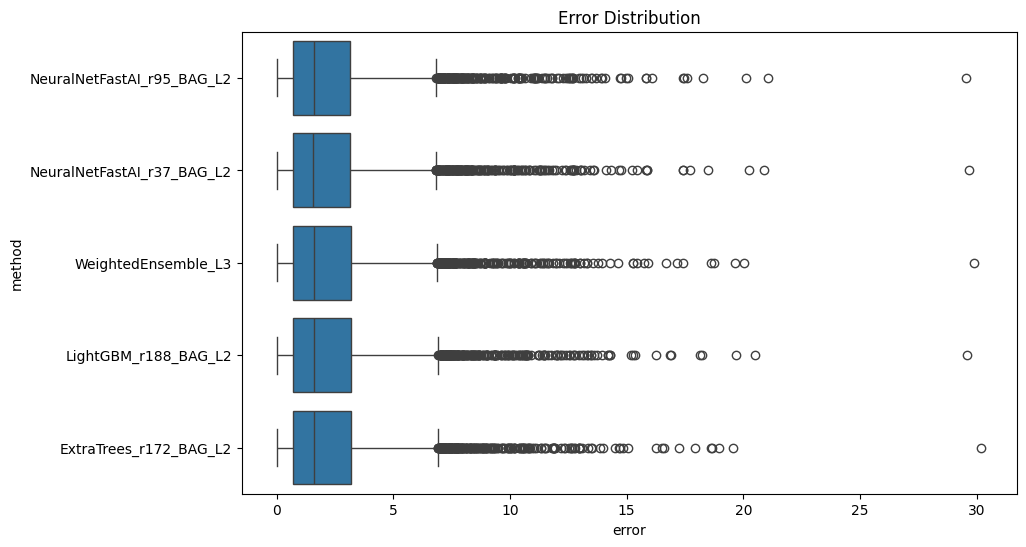

In [8]:
# method-wise error distribution
eda_utils.box_plot(ml_error_df, 'error', 'method', 'Error Distribution')

In [11]:
# dis_bin-wise error distribution
evaluation_utils.barplot(ml_eval_df, 'dis_bin', 'RMSE', 'distribution', hue='method')
evaluation_utils.barplot(ml_eval_df, 'dis_bin', 'adjusted_r2', 'distribution', hue='method')

ValueError: Could not interpret value `dis_bin` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

## Spatial Interpolation Method Evaluation

- boxplot: dis_bin-wise distribution, error distribution
- output: csv

1. Spatial Interpolation with Networks

    - GNNWR [Geographically neural network weighted regression for the accurate estimation of spatial non-stationarity](https://doi.org/10.1080/13658816.2019.1707834)

    - KCN [Kriging Convolutional Networks](https://doi.org/10.48550/arXiv.2306.09463)

    - GSARNN [A generalized spatial autoregressive neural network method for three-dimensional spatial interpolation](https://doi.org/10.5194/gmd-16-2777-2023)

    - DKNN [DKNN: deep kriging neural network for interpretable geospatial interpolation](https://doi.org/10.1080/13658816.2024.2347316)

2. Simple Spatial Interpolation

    - Kriging [PyKrige](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/)

    - KNN [scikit-learn-Nearest Neighbors regression](https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html)

    - RBF [Scipy-RBf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf)

    - IDW

In [ ]:
test_df = pd.read_csv('data/241026_Rockhead_Seoul_test(before_aumentation).csv')

In [ ]:
for i in range(8):
        
    for bin in test_df['dis_bin'].unique():

        error_df = pd.DataFrame(columns=['bin', 'method', 'y_true', 'y_pred', 'error'])

        bin_df = test_df[test_df['dis_bin'] == bin]
                                
        # X_test_bin = TabularDataset(bin_df.drop(['depth_start', 'dis_bin'], axis=1))
        # y_test_bin = bin_df['depth_start'].array

        # pred_y = predictor.predict(X_test_bin, ld_board.model[i])

        error = {'bin':np.full(y_test_bin.shape, bin), 'method':np.full(y_test_bin.shape, ld_board.model[i]),'y_true':y_test_bin, 'y_pred':pred_y, 'error':abs(y_test_bin-pred_y)}
        error_df = pd.concat([error_df, pd.DataFrame(error)], ignore_index=True)

        si_error_df = pd.concat([si_error_df, error_df], ignore_index=True)
    
    mae, mse, rmse, r2, adjusted_r2 = evaluation_utils.evaluation(error_df['y_true'], error_df['y_pred'], len(error_df), 7)
    result={'method':, 'mae':mae, 'mse':mse, 'rmse':rmse, 'r2':r2, 'adjusted_r2':adjusted_r2}
    si_eval_df = pd.concat([si_eval_df, pd.DataFrame(result)], ignore_index=True)

In [ ]:
si_eval_df.to_csv('data/241026_Spatial_Interpolation_Evaluation(before_aumentation).csv', index=False)

In [ ]:
# method-wise error distribution
eda_utils.box_plot(si_error_df, 'error', 'method', 'Error Distribution')

In [ ]:
# dis_bin-wise error distribution
evaluation_utils.barplot(si_eval_df, 'bin', 'RMSE', 'distribution', hue='method')
evaluation_utils.barplot(si_eval_df, 'bin', 'adjusted_r2', 'distribution', hue='method')

## Comparison Autogloun Model, Spatial Interpolation Method

- multi-barplot: dis_bin

In [ ]:
error_df = pd.concat([ml_error_df, si_error_df], ignore_index=True)
evaluation_df = pd.concat([ml_eval_df, si_eval_df], ignore_index=True)

In [ ]:
# method-wise error distribution
eda_utils.box_plot(si_error_df, 'error', 'method', 'Error Distribution')

In [ ]:
# dis_bin-wise error distribution
evaluation_utils.barplot(si_eval_df, 'bin', 'RMSE', 'distribution', hue='method')
evaluation_utils.barplot(si_eval_df, 'bin', 'adjusted_r2', 'distribution', hue='method')

## Surface Visualization